In [1]:
!pip install pandas numpy matplotlib statsmodels scikit-learn tensorflow

In [2]:
!pip uninstall sparse -y  # Remove existing versions
!pip install "sparse<0.14"           # Install compatible sparse version
!pip install chainladder             # Reinstall chainladder

Found existing installation: sparse 0.13.0
Uninstalling sparse-0.13.0:
  Successfully uninstalled sparse-0.13.0
  Using cached sparse-0.13.0-py2.py3-none-any.whl.metadata (2.9 kB)
Using cached sparse-0.13.0-py2.py3-none-any.whl (77 kB)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def chain_ladder(triangle):
    n = triangle.shape[0]

    # Calculate incremental triangle
    incremental_triangle = np.zeros_like(triangle)
    incremental_triangle[:, 0] = triangle[:, 0]
    for j in range(1, n):
        incremental_triangle[:, j] = triangle[:, j] - triangle[:, j-1]

    # Calculate development factors (for each year of development)
    dev_factors = []
    for j in range(n-1):
        # Sum of incremental claims for the j-th and (j+1)-th development years
        numerator = np.nansum(incremental_triangle[j:, j+1])  # Claims for development year j+1
        denominator = np.nansum(incremental_triangle[j:, j])  # Claims for development year j
        dev_factors.append(numerator / denominator)

    # Project future claims based on development factors
    projected_triangle = triangle.copy()
    for i in range(1, n):  # Start from the second row (the first row is the origin year)
        for j in range(n-i):  # Only project for columns that are not yet filled
            # Project the future claims based on the previous value and development factor
            projected_triangle[i, j+i] = projected_triangle[i-1, j+i-1] * dev_factors[j]  # Use dev_factors[j] for each year

    # Calculate reserves (the total amount of claims yet to be incurred)
    reserves = np.nansum(projected_triangle) - np.nansum(triangle)

    return projected_triangle, reserves, dev_factors

In [19]:
import chainladder as cl

# Load the "GenIns" dataset (generic insurance)
triangle = cl.load_sample("genins")
cumulative_triangle = triangle.values[0, 0, :, :]
print(cumulative_triangle)

[[ 357848. 1124788. 1735330. 2218270. 2745596. 3319994. 3466336. 3606286.
  3833515. 3901463.]
 [ 352118. 1236139. 2170033. 3353322. 3799067. 4120063. 4647867. 4914039.
  5339085.      nan]
 [ 290507. 1292306. 2218525. 3235179. 3985995. 4132918. 4628910. 4909315.
       nan      nan]
 [ 310608. 1418858. 2195047. 3757447. 4029929. 4381982. 4588268.      nan
       nan      nan]
 [ 443160. 1136350. 2128333. 2897821. 3402672. 3873311.      nan      nan
       nan      nan]
 [ 396132. 1333217. 2180715. 2985752. 3691712.      nan      nan      nan
       nan      nan]
 [ 440832. 1288463. 2419861. 3483130.      nan      nan      nan      nan
       nan      nan]
 [ 359480. 1421128. 2864498.      nan      nan      nan      nan      nan
       nan      nan]
 [ 376686. 1363294.      nan      nan      nan      nan      nan      nan
       nan      nan]
 [ 344014.      nan      nan      nan      nan      nan      nan      nan
       nan      nan]]


In [20]:
projected_triangle_cl, reserves_cl, dev_factors = chain_ladder(cumulative_triangle)
print("\nChain-Ladder Projected Triangle:")
print(projected_triangle_cl)
print(f"\nChain-Ladder Reserves: {reserves_cl:.2f}")


Chain-Ladder Projected Triangle:
[[3.57848000e+05 1.12478800e+06 1.73533000e+06 2.21827000e+06
  2.74559600e+06 3.31999400e+06 3.46633600e+06 3.60628600e+06
  3.83351500e+06 3.90146300e+06]
 [3.52118000e+05 8.07746375e+05 1.05453863e+06 1.48004912e+06
  7.83379140e+05 1.06720583e+06            nan            nan
             nan            nan]
 [2.90507000e+05 1.29230600e+06 1.82327191e+06 9.88676732e+05
  1.26232210e+06 2.76649315e+05 4.14820053e+05            nan
             nan            nan]
 [3.10608000e+05 1.41885800e+06 2.19504700e+06 4.11554983e+06
  9.26928281e+05 1.07662446e+06 9.76983427e+04 1.61239446e+05
             nan            nan]
 [4.43160000e+05 1.13635000e+06 2.12833300e+06 2.89782100e+06
  9.28975560e+06 8.69036370e+05 9.18244419e+05 3.45020415e+04
  6.26733419e+04            nan]
 [3.96132000e+05 1.33321700e+06 2.18071500e+06 2.98575200e+06
  3.69171200e+06 2.09691445e+07 8.14760136e+05 7.83163346e+05
  1.21843507e+04 2.43609605e+04]
 [4.40832000e+05 1.28846

<ipython-input-18-299b1b4d2a1c>:20: RuntimeWarning: invalid value encountered in scalar divide
  dev_factors.append(numerator / denominator)


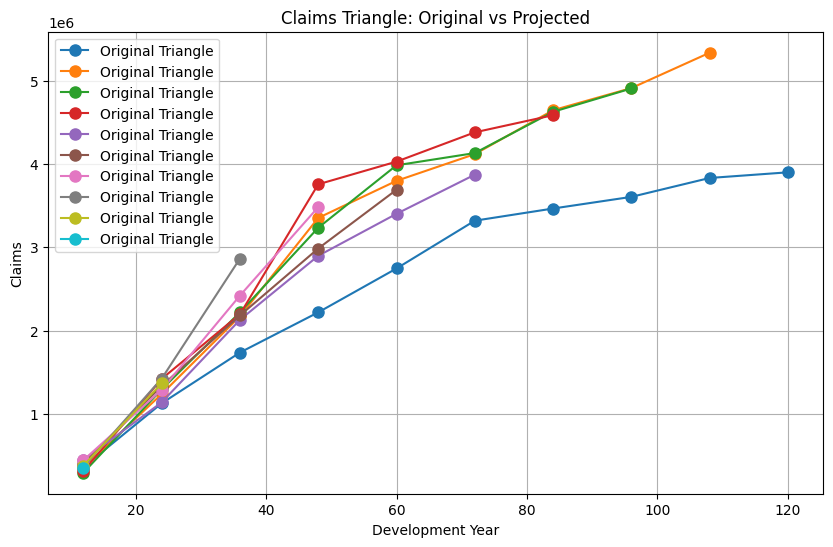

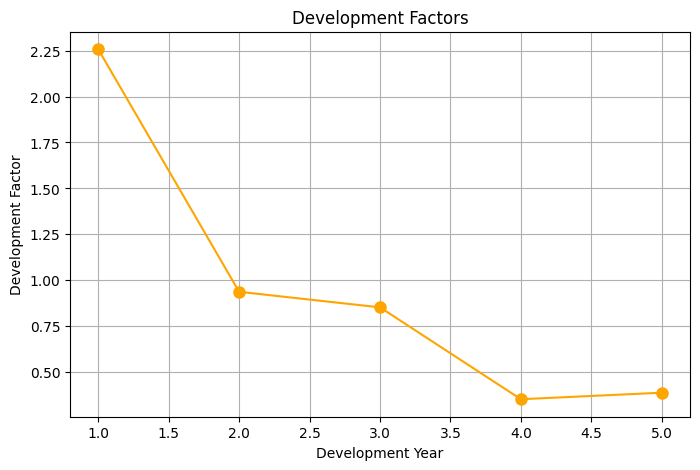

In [28]:
# Plotting the original and projected claims triangle
plt.figure(figsize=(10, 6))

# Plot the original triangle
plt.plot(triangle.T, 'o-', label='Original Triangle', markersize=8)

# Plot the projected triangle
#plt.plot(projected_triangle_cl.T, 's-', label='Projected Triangle', markersize=8)

plt.title("Claims Triangle: Original vs Projected")
plt.xlabel("Development Year")
plt.ylabel("Claims")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the development factors
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(dev_factors)+1), dev_factors, 'o-', label="Development Factors", markersize=8, color='orange')
plt.title("Development Factors")
plt.xlabel("Development Year")
plt.ylabel("Development Factor")
plt.grid(True)
plt.show()

In [36]:
def bootstrap_chain_ladder(triangle, n_simulations=1000):
    n = triangle.shape[0]
    # Fit Chain-Ladder to get development factors
    _, _, dev_factors = chain_ladder(triangle)

    # Calculate incremental claims
    incremental_triangle = np.zeros_like(triangle)
    incremental_triangle[:, 0] = triangle[:, 0]
    for j in range(1, n):
        incremental_triangle[:, j] = triangle[:, j] - triangle[:, j-1]

    # Identify upper triangle mask (non-NaN values)
    upper_mask = ~np.isnan(incremental_triangle)

    # Calculate Pearson residuals only for the upper triangle
    projected_incremental = np.zeros_like(incremental_triangle)
    for i in range(n):
        for j in range(n):
            if j == 0:
                projected_incremental[i, j] = incremental_triangle[i, j]
            else:
                if upper_mask[i, j]:
                    projected_incremental[i, j] = incremental_triangle[i, j]
                else:
                    projected_incremental[i, j] = projected_incremental[i, j-1] * dev_factors[j-1]

    # Avoid division by zero and negative variances
    projected_incremental = np.clip(projected_incremental, 1e-6, None)
    residuals = (incremental_triangle[upper_mask] - projected_incremental[upper_mask]) / np.sqrt(projected_incremental[upper_mask])
    residuals = residuals[np.isfinite(residuals)]  # Remove inf/NaN

    # Bootstrap loop
    bootstrap_reserves = []
    for _ in range(n_simulations):
        # Resample residuals with replacement
        sampled_residuals = np.random.choice(residuals, size=residuals.size, replace=True)

        # Create new incremental triangle (only perturb upper triangle)
        new_incremental = projected_incremental.copy()
        new_incremental[upper_mask] += sampled_residuals * np.sqrt(projected_incremental[upper_mask])
        new_incremental = np.clip(new_incremental, 0, None)  # Force non-negative

        # Convert to cumulative triangle
        new_cumulative = np.cumsum(new_incremental, axis=1)

        # Reapply Chain-Ladder
        _, reserves, _ = chain_ladder(new_cumulative)
        bootstrap_reserves.append(reserves)

    return np.array(bootstrap_reserves)

In [37]:
# Run Bootstrap
bootstrap_reserves = bootstrap_chain_ladder(cumulative_triangle, n_simulations=1000)
lower = np.percentile(bootstrap_reserves, 2.5)
median = np.percentile(bootstrap_reserves, 50)
upper = np.percentile(bootstrap_reserves, 97.5)

print(f"\nBootstrap Reserves (Median): {median:.2f}")
print(f"95% Confidence Interval: [{lower:.2f}, {upper:.2f}]")


Bootstrap Reserves (Median): 1995636217.19
95% Confidence Interval: [1995636217.19, 1995636217.19]


<ipython-input-18-299b1b4d2a1c>:20: RuntimeWarning: invalid value encountered in scalar divide
  dev_factors.append(numerator / denominator)


In [38]:
def poisson_glm(triangle):
    n = triangle.shape[0]
    incremental_triangle = np.zeros_like(triangle)
    incremental_triangle[:, 0] = triangle[:, 0]
    for j in range(1, n):
        incremental_triangle[:, j] = triangle[:, j] - triangle[:, j-1]

    # Prepare data (origin, development, value)
    data = []
    for i in range(n):
        for j in range(n):
            if not np.isnan(incremental_triangle[i, j]):
                data.append([i, j, incremental_triangle[i, j]])
    data = np.array(data, dtype=np.float64)  # Use float64 for precision
    X = data[:, :2]  # Origin and development
    y = data[:, 2]

    # Feature Scaling (critical for stability)
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_scaled = (X - X_mean) / X_std

    # Add intercept term
    X_scaled = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

    # Initialize coefficients (beta)
    beta = np.zeros(X_scaled.shape[1], dtype=np.float64)

    # Iteratively Reweighted Least Squares (IRLS)
    for _ in range(100):
        eta = X_scaled @ beta  # Linear predictor
        # Clip eta to prevent overflow
        eta_clipped = np.clip(eta, -20, 20)  # exp(20) ~ 4.8e8 is manageable
        mu = np.exp(eta_clipped)  # Poisson mean
        # Add small epsilon to avoid division by zero
        mu = np.clip(mu, 1e-10, None)
        weights = mu  # Weights for Poisson GLM
        z = eta_clipped + (y - mu) / mu  # Working response

        # Regularization (avoid singular matrix)
        XW = X_scaled.T * weights
        XWX = XW @ X_scaled + 1e-6 * np.eye(X_scaled.shape[1])  # Ridge regularization
        XWz = XW @ z

        try:
            beta_new = np.linalg.solve(XWX, XWz)
        except np.linalg.LinAlgError:
            beta_new = beta  # Fallback if matrix is singular

        # Check convergence
        if np.max(np.abs(beta_new - beta)) < 1e-6:
            break
        beta = beta_new

    # Predict missing incremental claims
    predicted_reserves = 0.0
    for i in range(n):
        for j in range(n):
            if np.isnan(triangle[i, j]):
                # Scale new features
                x_new = np.array([i, j], dtype=np.float64)
                x_scaled = (x_new - X_mean) / X_std
                x_scaled = np.r_[1.0, x_scaled]  # Add intercept
                eta = x_scaled @ beta
                mu = np.exp(np.clip(eta, -20, 20))
                predicted_reserves += mu

    return predicted_reserves

In [16]:
# Run GLM
reserves_glm = poisson_glm(cumulative_triangle)
print(f"\nGLM Estimated Reserve: {reserves_glm:.2f}")


GLM Estimated Reserve: 24410358.10


In [31]:
import chainladder as cl
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Load the GenIns dataset
triangle = cl.load_sample("genins")
cumulative_triangle = triangle.values[0, 0, :, :]

# Convert cumulative triangle to incremental claims
incremental_triangle = np.zeros_like(cumulative_triangle)
incremental_triangle[:, 0] = cumulative_triangle[:, 0]
for j in range(1, cumulative_triangle.shape[1]):
    incremental_triangle[:, j] = cumulative_triangle[:, j] - cumulative_triangle[:, j-1]

# Create DataFrame with origin, development, and incremental value
n_years = cumulative_triangle.shape[0]
data = pd.DataFrame({
    'origin': np.repeat(np.arange(n_years), n_years),
    'development': np.tile(np.arange(n_years), n_years),
    'value': incremental_triangle.flatten()
})

# Mask lower triangle (set to NaN)
for i in range(n_years):
    mask = (data['origin'] == i) & (data['development'] > (n_years - i - 1))
    data.loc[mask, 'value'] = np.nan

print("Full Dataset:")
print(data.head(10))

# Prepare data for Neural Network
upper_data = data.dropna(subset=['value'])  # Upper triangle (training)
lower_data = data[data['value'].isna()]     # Lower triangle (prediction)

# Features and target
X_train = upper_data[['origin', 'development']].values.astype(float)
y_train = upper_data['value'].values.astype(float)
X_pred = lower_data[['origin', 'development']].values.astype(float)

# Normalize features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_pred_scaled = scaler.transform(X_pred) if len(X_pred) > 0 else None

# Build Neural Network
model = Sequential([
    Dense(10, activation='relu', input_shape=(2,)),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train_scaled, y_train, epochs=100, verbose=0)

# Predict reserves
if X_pred_scaled is not None:
    nn_pred = model.predict(X_pred_scaled).flatten()
    nn_reserve = np.sum(nn_pred)
else:
    nn_reserve = 0.0

print(f"\nNeural Network Estimated Reserve: {nn_reserve:.2f}")

Full Dataset:
   origin  development     value
0       0            0  357848.0
1       0            1  766940.0
2       0            2  610542.0
3       0            3  482940.0
4       0            4  527326.0
5       0            5  574398.0
6       0            6  146342.0
7       0            7  139950.0
8       0            8  227229.0
9       0            9   67948.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Neural Network Estimated Reserve: 331.31


In [40]:
print("\nFinal Reserve Estimates:")
print(f"- Chain-Ladder: {reserves_cl:.2f}")
print(f"- Bootstrap Median: {median:.2f}")
print(f"- GLM: {reserves_glm:.2f}")
print(f"- Bootstrap 95% CI: [{lower:.2f}, {upper:.2f}]")


Final Reserve Estimates:
- Chain-Ladder: 916478918.49
- Bootstrap Median: 1995636217.19
- GLM: 24410358.10
- Bootstrap 95% CI: [1995636217.19, 1995636217.19]


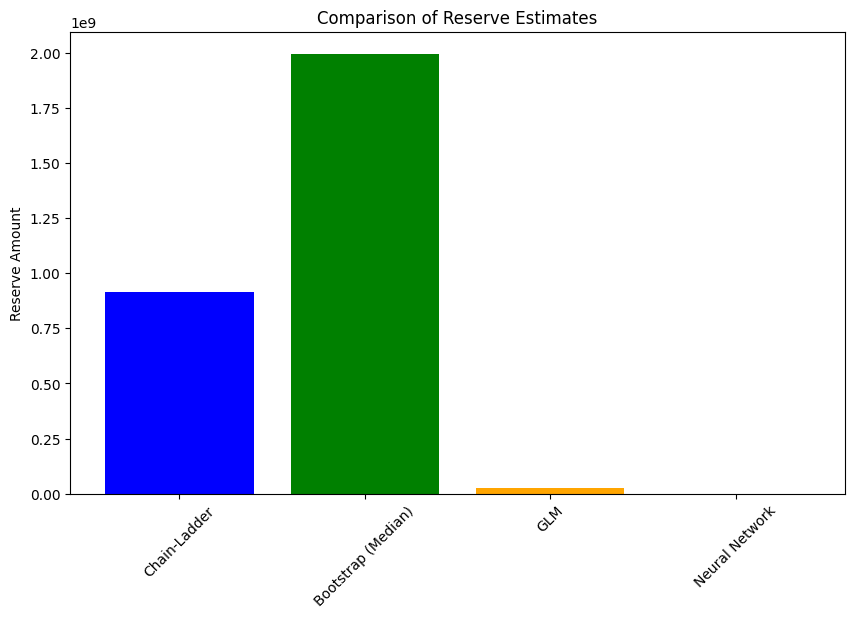

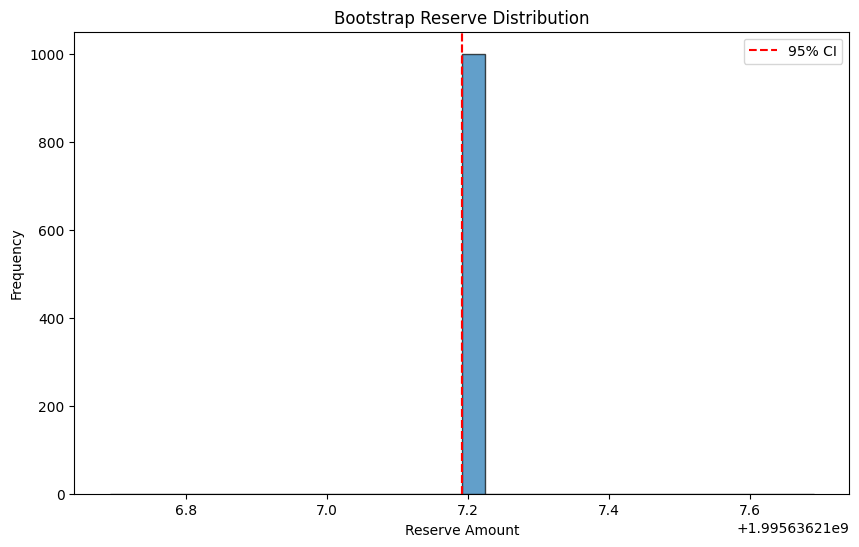

In [41]:
# Aggregate results
methods = ['Chain-Ladder', 'Bootstrap (Median)', 'GLM', 'Neural Network']
reserves = [
    reserves_cl.sum(),
    median,
    reserves_glm,
    nn_reserve
]

# Plot results
plt.figure(figsize=(10, 6))
plt.bar(methods, reserves, color=['blue', 'green', 'orange', 'red'])
plt.title('Comparison of Reserve Estimates')
plt.ylabel('Reserve Amount')
plt.xticks(rotation=45)
plt.show()

# Plot Bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_reserves, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(lower, color='red', linestyle='--', label='95% CI')
plt.axvline(upper, color='red', linestyle='--')
plt.title('Bootstrap Reserve Distribution')
plt.xlabel('Reserve Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()